# Face Recognition

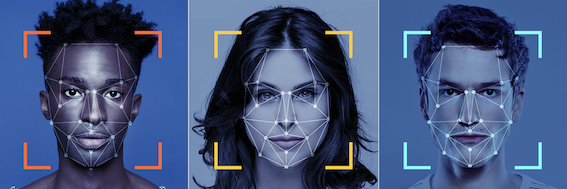

In this notebook we'll dive into face recognition framework and train neural network for face recognition task, play with losses and metrics.

We will train neural network on [CelebA dataset](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html).

As you see on the site, images of celebA dataset look like this:


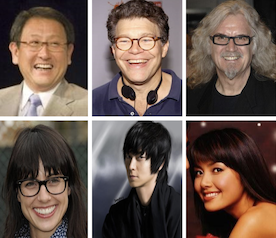

But we won't train a neural network for face recognition on those images. We'll need to preprocess them first. Let's see why we need it and how we need to preprocess them.

Let's look at how face recognition systems work:

## Face recognition model training and inference setup

This section describes how face recognition models are trained, what data alignment is and how the inference of face recognition model looks like. If you are familiar with this, you can skip this section.

### Model training

To train face recognition model on any facial dataset images must be aligned first. This step is very important to achieve a good quality of face recognition.

What is alignment: it consists of three steps:
1. Given image, identify facial landmarks on the image (coordinates of eyes, nose and mouth points). Separate neural network can be used there which was trained to identify landmarks on facial images. You can refer to [PyTorch Landmarks tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) to see how this works.
2. Rotate all the images in the dataset so that eyes of the person on every image lie on a certain pre-defined horizontal line.
3. Scale all the images in the dataset so that the size of the faces are approximately identical.

Here's an example of what we would get after alignment of all the images of Aaron Peirsol from our dataset:

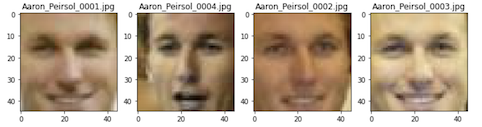

You see that eyes of all the faces lie on one horizontal line and all the faces have almost the same size. If we align all the images in the dataset, we can then train a neural network on aligned images.

**Why we need the alignment procedure**: the alignment of all faces in dataset makes the task of facial recognition easier for the model. If all the faces that model sees are of the same size and have their landmarks (eyes, nose, etc) on almost the same parts of the images, it is easier for the model to learn to identify a person on the image. The model diesn't need to "search" for the face and eyes positions on the image befire performing a recognition.

If you are interested, you can also train a model on non-aligned images, but you'll see that it would perform badly. It is possible though to train a model for face recognition without pre-alignment of all the faces, but this would require a huge amount of data — more that almost any company has. The only company that has openly presented its face recognition system that does not require special alignment is Facebook — their neural network was trained on a really huge amount of data using a special trick to avoid alignment. You can read more details [here](https://research.fb.com/publications/deepface-closing-the-gap-to-human-level-performance-in-face-verification/)

### Model inference

So let's see how the model trained on aligned faces can be used in real world:

Let's assume you owe a company and you want to build a face recognition system for your working office. You decided to hang some cameras around the office and want them to be able to recognize faces of all your employees when they are sitting / walking around the office (we let you decide by yourself why you would need such a system in your office)


A system for face recognition typically conststs of 3 stages:
- face detection
- face alignment
- face recognition

Let's discuss them in detail:

**Face detection**

When the camera is hanged on the wall it records a video and splits the video into single images, like this:

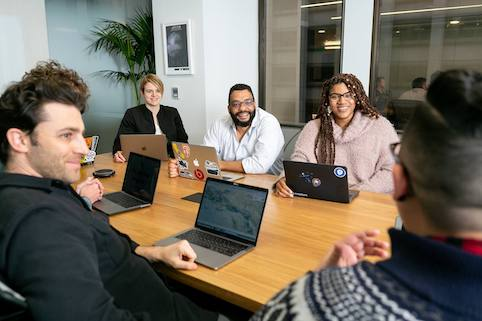

To be able to recognize all the faces on the photo you need first to detect all the faces that are present on the photo, like this:

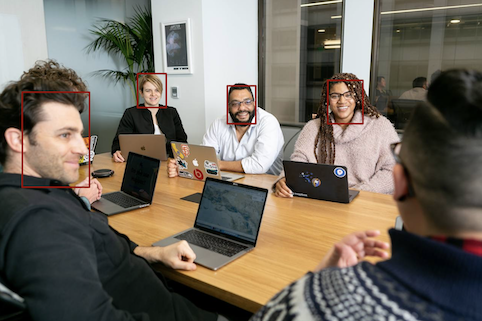

That is the first part — detection. You could use any neural network that can detect humans for this.

**Face alignment**

The second stage is to align all the faces found. The alignment procedure here should be the same as used to align training images.

So we'll get an image of a guy on a photo aligned like this:

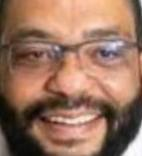

**Face recognition**

On the third stage we use the neural network that we trained to recognize a face.

So that's how the face recognition models pipeline work. You can also read about it more on [this link](https://www.nytimes.com/wirecutter/blog/how-facial-recognition-works/) (and using internet search)

## Neural network model architecture

Let's discuss how model for face recognition should look like.



The easiest and, actually, the most used way to build a neural network for face recognition is to build it as a **simple classifier**.

Assume we have a dataset with photos of N different people. Then we can build a neural network to classify all the images from the dataset into N classes. Each class refers to one unique person in the dataset.

**How do we recognize new people by this network then?** We actually want the network for face recognition to be able to recognize not only the people which are in training set, but almost every person in the world.

That is how: after training the model, we'll drop it's last classification layer. After that when we'll pass an image of the person through network, we'll get the output of the pre-last layer — it's **the embedding of the image**. Having embeddings of two different images we can compare them using **cosine distance**. The less the distance is — the higher the probability that those two photos belong to one person is.

Using that technique we can get embeddings of every image — even of unseen people, compare them, and reveal images belonging to same people.

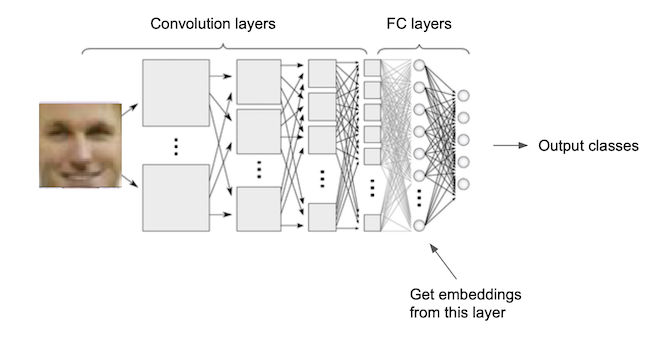

## Build a neural network for faces classification as discribed above.

### Dataset

We will train out face recognition network on part of the [CelebA dataset](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). But we'll use a version of it that has all the images in it aligned and cropped. You can download the dataset using this link: https://disk.yandex.ru/d/S8f03spLIA1wrw or using the code below:

In [1]:
! pip install wldhx.yadisk-direct
! curl -L $(yadisk-direct https://disk.yandex.ru/d/S8f03spLIA1wrw) -o celebA_train.zip
! unzip -qq celebA_train.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  162M  100  162M    0     0  9841k      0  0:00:16  0:00:16 --:--:-- 15.1M


Let's look at the data first:

In [2]:
! ls celebA_train_500/

celebA_anno.txt  celebA_imgs  celebA_train_split.txt


- celebA_imgs — folder with aligned images
- celebA_anno.txt — file with annotations: which person each image corresponds to
- celebA_train_split.txt — file with train/val/test info

In [3]:
import os
import cv2
import numpy as np
from PIL import Image
from skimage import io, transform

import torch
from torch import nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset

import matplotlib.pyplot as plt

Let's visualize some images to understand what we're dealing with:

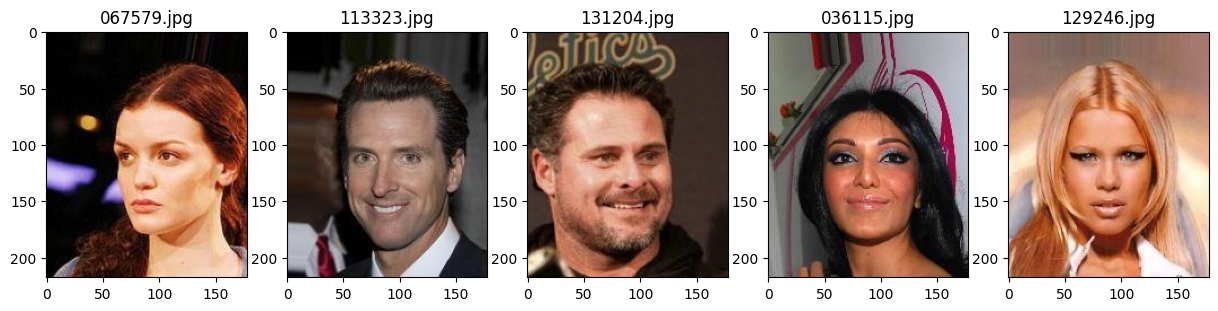

In [4]:
def show_imgs(images_names, crop=False):
    imgs = []
    for img in images_names:
      img = np.array(Image.open(os.path.join('celebA_train_500/celebA_imgs/', img)))
      if crop:
        img = img[77:-41, 45:-50]
      imgs.append(img)

    f, axes= plt.subplots(1, len(imgs), figsize=(3*len(imgs),5))
    for i, axis in enumerate(axes):
        axes[i].imshow(imgs[i], cmap='gray')
        axes[i].set_title(images_names[i])
    plt.show()

images_names = os.listdir('./celebA_train_500/celebA_imgs/')[:5]
show_imgs(images_names)


To make it easier for the neural network to classify images, we'll crop them so that only face is left shown. So they'll become like that:

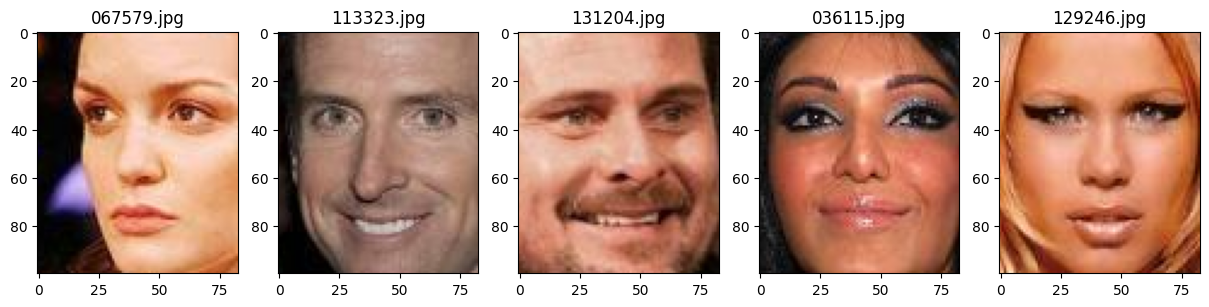

In [5]:
images_names = os.listdir('./celebA_train_500/celebA_imgs/')[:5]
show_imgs(images_names, crop=True)

### Train Neural Network

Let's build a Datasets and network using these images:

In [6]:
def get_paths(dataset_type='train'):
    '''
    a function that returnes list of images paths for a given type of the dataset
    params:
      dataset_type: one of 'train', 'val', 'test'
    '''

    labels_dict = {
        'train': 0,
        'val': 1,
        'test': 2,
    }

    f = open('celebA_train_500/celebA_train_split.txt', 'r')
    lines = f.readlines()
    f.close()

    lines = [x.strip().split() for x in lines]
    lines = [x[0] for x in lines if int(x[1]) == labels_dict[dataset_type]]

    images_paths = []
    for filename in lines:
        images_paths.append(os.path.join('celebA_train_500/celebA_imgs/', filename))

    return np.array(images_paths)


class celebADataset(Dataset):
    """Feel free to rewrite it. For ex. cache all images in RAM to increase training speed"""
    def __init__(self, dataset_type, transform, aug=None,):
        self.images = get_paths(dataset_type=dataset_type)

        f = open('celebA_train_500/celebA_anno.txt', 'r')
        labels = f.readlines()
        f.close()
        labels = [x.strip().split() for x in labels]
        labels = {x:y for x, y in labels}
        self.labels = [int(labels[x.split('/')[-1]]) for x in self.images]

        self.transform = transform
        self.aug = aug

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        label = self.labels[idx]

        image = np.array(Image.open(img_name))
        # cropping images
        image = Image.fromarray(image[77:-41, 45:-50])

        if self.aug:
            sample = self.aug(
                image=image,
            )
        else:
            sample = {
                'image': image,
                'label': label,
            }

        sample['image'] = self.transform(sample['image'])

        return sample

In [7]:
transform = transforms.Compose([
      transforms.Resize(160),
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

train_data = celebADataset('train', transform)
val_data = celebADataset('val', transform)
test_data = celebADataset('test', transform)

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
train_data[0]

{'image': tensor([[[ 0.4166,  0.3309,  0.1768,  ...,  0.3994,  0.5536,  0.6392],
          [ 0.5022,  0.3481,  0.0741,  ...,  0.3994,  0.5022,  0.5536],
          [ 0.6563,  0.3823, -0.0972,  ...,  0.3994,  0.3823,  0.3994],
          ...,
          [-0.5253, -0.4054, -0.1828,  ...,  1.8208,  1.8379,  1.8379],
          [-0.6452, -0.5938, -0.5253,  ...,  1.8379,  1.8208,  1.7865],
          [-0.6965, -0.6965, -0.6965,  ...,  1.8550,  1.8037,  1.7694]],
 
         [[-0.3200, -0.3901, -0.5301,  ..., -0.6877, -0.4601, -0.3375],
          [-0.2325, -0.3725, -0.6352,  ..., -0.7052, -0.5301, -0.4426],
          [-0.0574, -0.3200, -0.8102,  ..., -0.7227, -0.6527, -0.6176],
          ...,
          [-1.5105, -1.4055, -1.1954,  ...,  0.6604,  0.6779,  0.6604],
          [-1.5630, -1.5105, -1.4405,  ...,  0.7129,  0.6954,  0.6779],
          [-1.5805, -1.5805, -1.5805,  ...,  0.7479,  0.7129,  0.6954]],
 
         [[-0.5321, -0.6018, -0.7064,  ..., -0.8284, -0.6541, -0.5495],
          [-0.4275,

In [ ]:
labels = set()
for el in train_data:
  labels.add(el['label'])
len(labels)

500

Вот столько в трейне у нас разных людей

Train a model on train_data using val_data for validation. We use standard CE loss.

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
from torchvision.models import resnet18

resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
class classify_model(nn.Module):
    def __init__(self):
        super(classify_model, self).__init__()
        model = resnet18(pretrained=True)
        model.fc = nn.Identity()
        self.resnet = model
        self.head = nn.Sequential(   # приделаем еще голову для файн тюна
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 500)
        )

    def forward(self, x):
        x = x.to(device)
        return self.head(self.resnet(x))

In [11]:
import torch.nn.functional as F

In [12]:
def compute_loss(predictions, gt):
    return F.cross_entropy(predictions, gt).mean()

In [ ]:
model = classify_model()
model = model.to(device)
for param in model.resnet.parameters(): # сначала поучим только голову
    param.requires_grad = False
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
import numpy as np
import time
from tqdm import tqdm


def eval_model(model, data_generator):
    accuracy = []
    model.train(False) # disable dropout / use averages for batch_norm
    with torch.no_grad():
        for batch in data_generator:
            X_batch = batch['image'].to(device)
            y_batch = batch['label'].to(device)
            logits = model(X_batch)
            y_pred = logits.max(1)[1].data
            accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))
    return np.mean(accuracy)


def train_model(model, optimizer, train_data_generator):
    train_loss = []
    model.train(True) # enable dropout / batch_norm training behavior
    for batch in tqdm(train_data_generator):
        X_batch = batch['image'].to(device)
        y_batch = batch['label'].to(device)
        optimizer.zero_grad()

        predictions = model(X_batch)
        loss = compute_loss(predictions, y_batch)

        # backward
        loss.backward()
        optimizer.step()

        # metrics
        train_loss.append(loss.cpu().data.numpy())
    return np.mean(train_loss)


def train_loop(model, optimizer, train_data_generator, val_data_generator, num_epochs):
    """
    num_epochs - total amount of full passes over training data
    """
    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss = train_model(model, optimizer, train_data_generator)

        val_accuracy = eval_model(model, val_data_generator)

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_accuracy * 100))

In [ ]:
train_loop(model, optimizer, train_loader, val_loader, num_epochs=20)

100%|██████████| 134/134 [00:23<00:00,  5.67it/s]


Epoch 1 of 20 took 28.813s
  training loss (in-iteration): 	6.140976
  validation accuracy: 			0.99 %


100%|██████████| 134/134 [00:23<00:00,  5.66it/s]


Epoch 2 of 20 took 28.426s
  training loss (in-iteration): 	5.506238
  validation accuracy: 			4.20 %


100%|██████████| 134/134 [00:25<00:00,  5.29it/s]


Epoch 3 of 20 took 30.642s
  training loss (in-iteration): 	4.905270
  validation accuracy: 			7.08 %


100%|██████████| 134/134 [00:23<00:00,  5.74it/s]


Epoch 4 of 20 took 28.614s
  training loss (in-iteration): 	4.429999
  validation accuracy: 			9.68 %


100%|██████████| 134/134 [00:28<00:00,  4.71it/s]


Epoch 5 of 20 took 37.196s
  training loss (in-iteration): 	4.068621
  validation accuracy: 			12.75 %


100%|██████████| 134/134 [00:23<00:00,  5.59it/s]


Epoch 6 of 20 took 28.625s
  training loss (in-iteration): 	3.774777
  validation accuracy: 			14.72 %


100%|██████████| 134/134 [00:23<00:00,  5.62it/s]


Epoch 7 of 20 took 28.499s
  training loss (in-iteration): 	3.508281
  validation accuracy: 			15.64 %


100%|██████████| 134/134 [00:25<00:00,  5.18it/s]


Epoch 8 of 20 took 31.065s
  training loss (in-iteration): 	3.295788
  validation accuracy: 			15.19 %


100%|██████████| 134/134 [00:24<00:00,  5.55it/s]


Epoch 9 of 20 took 28.915s
  training loss (in-iteration): 	3.043430
  validation accuracy: 			17.23 %


100%|██████████| 134/134 [00:23<00:00,  5.63it/s]


Epoch 10 of 20 took 28.876s
  training loss (in-iteration): 	2.845164
  validation accuracy: 			18.00 %


100%|██████████| 134/134 [00:24<00:00,  5.58it/s]


Epoch 11 of 20 took 29.219s
  training loss (in-iteration): 	2.663380
  validation accuracy: 			18.61 %


100%|██████████| 134/134 [00:23<00:00,  5.70it/s]


Epoch 12 of 20 took 28.237s
  training loss (in-iteration): 	2.451554
  validation accuracy: 			19.13 %


100%|██████████| 134/134 [00:24<00:00,  5.55it/s]


Epoch 13 of 20 took 29.223s
  training loss (in-iteration): 	2.316205
  validation accuracy: 			19.66 %


100%|██████████| 134/134 [00:23<00:00,  5.78it/s]


Epoch 14 of 20 took 28.446s
  training loss (in-iteration): 	2.120029
  validation accuracy: 			19.41 %


100%|██████████| 134/134 [00:23<00:00,  5.64it/s]


Epoch 15 of 20 took 28.453s
  training loss (in-iteration): 	2.016587
  validation accuracy: 			19.66 %


100%|██████████| 134/134 [00:23<00:00,  5.70it/s]


Epoch 16 of 20 took 28.282s
  training loss (in-iteration): 	1.889577
  validation accuracy: 			22.11 %


100%|██████████| 134/134 [00:23<00:00,  5.61it/s]


Epoch 17 of 20 took 29.258s
  training loss (in-iteration): 	1.738340
  validation accuracy: 			20.28 %


100%|██████████| 134/134 [00:23<00:00,  5.66it/s]


Epoch 18 of 20 took 28.314s
  training loss (in-iteration): 	1.635747
  validation accuracy: 			20.45 %


100%|██████████| 134/134 [00:23<00:00,  5.70it/s]


Epoch 19 of 20 took 28.126s
  training loss (in-iteration): 	1.499350
  validation accuracy: 			21.02 %


100%|██████████| 134/134 [00:23<00:00,  5.65it/s]


Epoch 20 of 20 took 28.889s
  training loss (in-iteration): 	1.417829
  validation accuracy: 			19.87 %


In [ ]:
for param in model.resnet.parameters(): # теперь обучаем все вместе
    param.requires_grad = True
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)

In [ ]:
train_loop(model, optimizer, train_loader, val_loader, num_epochs=20)

100%|██████████| 134/134 [00:32<00:00,  4.16it/s]


Epoch 1 of 20 took 37.305s
  training loss (in-iteration): 	4.209768
  validation accuracy: 			19.86 %


100%|██████████| 134/134 [00:31<00:00,  4.20it/s]


Epoch 2 of 20 took 36.973s
  training loss (in-iteration): 	3.020360
  validation accuracy: 			27.37 %


100%|██████████| 134/134 [00:32<00:00,  4.11it/s]


Epoch 3 of 20 took 37.570s
  training loss (in-iteration): 	2.364110
  validation accuracy: 			28.21 %


100%|██████████| 134/134 [00:32<00:00,  4.17it/s]


Epoch 4 of 20 took 37.182s
  training loss (in-iteration): 	1.935884
  validation accuracy: 			38.57 %


100%|██████████| 134/134 [00:32<00:00,  4.17it/s]


Epoch 5 of 20 took 37.314s
  training loss (in-iteration): 	1.588206
  validation accuracy: 			37.72 %


100%|██████████| 134/134 [00:32<00:00,  4.18it/s]


Epoch 6 of 20 took 37.226s
  training loss (in-iteration): 	1.285242
  validation accuracy: 			45.47 %


100%|██████████| 134/134 [00:32<00:00,  4.16it/s]


Epoch 7 of 20 took 37.304s
  training loss (in-iteration): 	1.128087
  validation accuracy: 			49.01 %


100%|██████████| 134/134 [00:32<00:00,  4.12it/s]


Epoch 8 of 20 took 37.687s
  training loss (in-iteration): 	0.948132
  validation accuracy: 			47.60 %


100%|██████████| 134/134 [00:31<00:00,  4.19it/s]


Epoch 9 of 20 took 37.084s
  training loss (in-iteration): 	0.838179
  validation accuracy: 			53.28 %


100%|██████████| 134/134 [00:32<00:00,  4.17it/s]


Epoch 10 of 20 took 37.195s
  training loss (in-iteration): 	0.689576
  validation accuracy: 			49.26 %


100%|██████████| 134/134 [00:32<00:00,  4.18it/s]


Epoch 11 of 20 took 37.149s
  training loss (in-iteration): 	0.634809
  validation accuracy: 			52.30 %


100%|██████████| 134/134 [00:31<00:00,  4.21it/s]


Epoch 12 of 20 took 36.817s
  training loss (in-iteration): 	0.566687
  validation accuracy: 			51.51 %


100%|██████████| 134/134 [00:31<00:00,  4.21it/s]


Epoch 13 of 20 took 37.201s
  training loss (in-iteration): 	0.536456
  validation accuracy: 			55.77 %


100%|██████████| 134/134 [00:32<00:00,  4.14it/s]


Epoch 14 of 20 took 37.275s
  training loss (in-iteration): 	0.486232
  validation accuracy: 			57.32 %


100%|██████████| 134/134 [00:32<00:00,  4.17it/s]


Epoch 15 of 20 took 36.938s
  training loss (in-iteration): 	0.461141
  validation accuracy: 			55.41 %


100%|██████████| 134/134 [00:32<00:00,  4.13it/s]


Epoch 16 of 20 took 37.236s
  training loss (in-iteration): 	0.467212
  validation accuracy: 			54.47 %


100%|██████████| 134/134 [00:32<00:00,  4.16it/s]


Epoch 17 of 20 took 37.088s
  training loss (in-iteration): 	0.377329
  validation accuracy: 			58.37 %


100%|██████████| 134/134 [00:36<00:00,  3.70it/s]


Epoch 18 of 20 took 41.484s
  training loss (in-iteration): 	0.341279
  validation accuracy: 			56.65 %


100%|██████████| 134/134 [00:34<00:00,  3.84it/s]


Epoch 19 of 20 took 39.350s
  training loss (in-iteration): 	0.351093
  validation accuracy: 			55.82 %


100%|██████████| 134/134 [00:32<00:00,  4.10it/s]


Epoch 20 of 20 took 37.179s
  training loss (in-iteration): 	0.346767
  validation accuracy: 			56.55 %


In [ ]:
for param in optimizer.param_groups:
  param['lr'] = 1e-4

In [ ]:
train_loop(model, optimizer, train_loader, val_loader, num_epochs=20)

100%|██████████| 134/134 [00:32<00:00,  4.10it/s]


Epoch 1 of 20 took 37.117s
  training loss (in-iteration): 	0.183611
  validation accuracy: 			66.95 %


100%|██████████| 134/134 [00:32<00:00,  4.08it/s]


Epoch 2 of 20 took 37.384s
  training loss (in-iteration): 	0.078183
  validation accuracy: 			67.94 %


100%|██████████| 134/134 [00:32<00:00,  4.10it/s]


Epoch 3 of 20 took 37.058s
  training loss (in-iteration): 	0.053887
  validation accuracy: 			68.92 %


100%|██████████| 134/134 [00:36<00:00,  3.64it/s]


Epoch 4 of 20 took 41.271s
  training loss (in-iteration): 	0.044111
  validation accuracy: 			69.60 %


100%|██████████| 134/134 [00:32<00:00,  4.08it/s]


Epoch 5 of 20 took 37.244s
  training loss (in-iteration): 	0.037879
  validation accuracy: 			70.28 %


100%|██████████| 134/134 [00:32<00:00,  4.11it/s]


Epoch 6 of 20 took 37.097s
  training loss (in-iteration): 	0.035110
  validation accuracy: 			69.65 %


100%|██████████| 134/134 [00:33<00:00,  4.04it/s]


Epoch 7 of 20 took 37.641s
  training loss (in-iteration): 	0.033836
  validation accuracy: 			70.01 %


100%|██████████| 134/134 [00:32<00:00,  4.12it/s]


Epoch 8 of 20 took 37.021s
  training loss (in-iteration): 	0.027067
  validation accuracy: 			70.39 %


100%|██████████| 134/134 [00:32<00:00,  4.12it/s]


Epoch 9 of 20 took 36.994s
  training loss (in-iteration): 	0.028431
  validation accuracy: 			69.70 %


100%|██████████| 134/134 [00:32<00:00,  4.07it/s]


Epoch 10 of 20 took 37.366s
  training loss (in-iteration): 	0.025906
  validation accuracy: 			70.69 %


100%|██████████| 134/134 [00:32<00:00,  4.09it/s]


Epoch 11 of 20 took 37.343s
  training loss (in-iteration): 	0.018877
  validation accuracy: 			71.00 %


100%|██████████| 134/134 [00:33<00:00,  4.01it/s]


Epoch 12 of 20 took 37.885s
  training loss (in-iteration): 	0.014697
  validation accuracy: 			70.69 %


100%|██████████| 134/134 [00:32<00:00,  4.07it/s]


Epoch 13 of 20 took 37.440s
  training loss (in-iteration): 	0.018011
  validation accuracy: 			71.00 %


100%|██████████| 134/134 [00:33<00:00,  4.03it/s]


Epoch 14 of 20 took 37.688s
  training loss (in-iteration): 	0.020160
  validation accuracy: 			71.48 %


100%|██████████| 134/134 [00:32<00:00,  4.08it/s]


Epoch 15 of 20 took 37.304s
  training loss (in-iteration): 	0.017102
  validation accuracy: 			70.39 %


100%|██████████| 134/134 [00:32<00:00,  4.12it/s]


Epoch 16 of 20 took 36.932s
  training loss (in-iteration): 	0.014448
  validation accuracy: 			70.87 %


100%|██████████| 134/134 [00:32<00:00,  4.10it/s]


Epoch 17 of 20 took 37.074s
  training loss (in-iteration): 	0.018377
  validation accuracy: 			70.50 %


100%|██████████| 134/134 [00:32<00:00,  4.10it/s]


Epoch 18 of 20 took 37.243s
  training loss (in-iteration): 	0.015807
  validation accuracy: 			69.92 %


100%|██████████| 134/134 [00:32<00:00,  4.12it/s]


Epoch 19 of 20 took 36.959s
  training loss (in-iteration): 	0.015943
  validation accuracy: 			71.21 %


100%|██████████| 134/134 [00:32<00:00,  4.08it/s]


Epoch 20 of 20 took 37.295s
  training loss (in-iteration): 	0.014238
  validation accuracy: 			70.59 %


In [ ]:
from google.colab import files

torch.save(model.state_dict(), 'model_classif1')
files.download('model_classif1')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Code for model evaluating (you can modify it if you want):

In [14]:
def evaluate(model, dataloader, loss_fn):

    losses = []

    num_correct = 0
    num_elements = 0

    for i, batch in enumerate(dataloader):

        X_batch, y_batch = batch['image'], batch['label']
        num_elements += len(y_batch)

        with torch.no_grad():
            logits = model(X_batch.to(device))

            loss = loss_fn(logits, y_batch.to(device))
            losses.append(loss.item())

            y_pred = torch.argmax(logits, dim=1)

            num_correct += torch.sum(y_pred.cpu() == y_batch)

    accuracy = num_correct / num_elements

    return accuracy.numpy(), np.mean(losses)

In [ ]:
test_accuracy, test_loss = evaluate(model, test_loader, compute_loss)
test_accuracy, test_loss

(array(0.7086218, dtype=float32), 1.7823467302322387)

Как раз нужное качество получили на тесте

**Cosine similarity calculation**: drop the last layer of trained network. Get embeddings for some images from train set and for images from test set. Calculate cosine similarities between embeddings corresponding to the pictures of the same person and different people

In [15]:
import copy

In [ ]:
model_wo_last = copy.deepcopy(model)
model_wo_last.head = model_wo_last.head[:4]
model_wo_last.head

Sequential(
  (0): Linear(in_features=512, out_features=1024, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=1024, out_features=1024, bias=True)
)

In [ ]:
train_representations = []
test_repr = []
model_wo_last.train(False)
with torch.no_grad():
  for i in range(0, 300, 100):
    img = train_data[i]['image'].unsqueeze(0).to(device)
    label = train_data[i]['label']
    out = model_wo_last(img).squeeze()
    train_representations.append((out / (out ** 2).sum() ** 0.5, label)) # переводим наши эмбеддинги на единичную сферу
  for el in tqdm(test_data):
    img = el['image'].unsqueeze(0).to(device)
    label = el['label']
    out = model_wo_last(img).squeeze()
    test_repr.append((out / (out ** 2).sum() ** 0.5, label))

100%|██████████| 1589/1589 [00:08<00:00, 183.05it/s]


In [ ]:
train_representations

[(tensor([-5.6858e-02, -4.6585e-10, -5.2935e-04,  ..., -4.6846e-02,
          -3.3447e-04, -3.4711e-04], device='cuda:0'),
  0),
 (tensor([ 1.8705e-02, -4.3684e-09, -6.4728e-04,  ..., -3.6169e-02,
          -4.9454e-04, -5.3283e-04], device='cuda:0'),
  4),
 (tensor([-5.0600e-02, -7.6844e-09, -7.6344e-04,  ..., -9.8288e-02,
          -5.0964e-04, -6.9545e-04], device='cuda:0'),
  9)]

In [ ]:
cos = nn.CosineSimilarity(dim=0, eps=1e-6)

first_img_sim_same_person = []
first_img_sim_other_person = []
for el in test_repr:
  if el[1] == train_representations[0][1]:
    first_img_sim_same_person.append(cos(el[0], train_representations[0][0]))
  else:
    first_img_sim_other_person.append(cos(el[0], train_representations[0][0]))

In [ ]:
print('similarity with same person (label 0):', sum(first_img_sim_same_person).item() / len(first_img_sim_same_person))

similarity with same person (label 0): 0.879688560962677


In [ ]:
print('similarity with other person (label not 0):', sum(first_img_sim_other_person).item() / len(first_img_sim_other_person))

similarity with other person (label not 0): 0.43123594458546927


In [ ]:
sec_img_sim_same_person = []
sec_img_sim_other_person = []
for el in test_repr:
  if el[1] == train_representations[1][1]:
    sec_img_sim_same_person.append(cos(el[0], train_representations[1][0]))
  else:
    sec_img_sim_other_person.append(cos(el[0], train_representations[1][0]))

In [ ]:
print('similarity with same person (label 4):', sum(sec_img_sim_same_person).item() / len(sec_img_sim_same_person))

similarity with same person (label 4): 0.6937879721323649


In [ ]:
print('similarity with other person (label not 4):', sum(sec_img_sim_other_person).item() / len(sec_img_sim_other_person))

similarity with other person (label not 4): 0.4400661319381502


In [ ]:
cos = nn.CosineSimilarity(dim=0, eps=1e-6)

third_img_sim_same_person = []
third_img_sim_other_person = []
for el in test_repr:
  if el[1] == train_representations[2][1]:
    third_img_sim_same_person.append(cos(el[0], train_representations[2][0]))
  else:
    third_img_sim_other_person.append(cos(el[0], train_representations[2][0]))

In [ ]:
print('similarity with same person (label 9):', sum(third_img_sim_same_person).item() / len(third_img_sim_same_person))

similarity with same person (label 9): 0.825972318649292


In [ ]:
print('similarity with other person (label not 9):', sum(third_img_sim_other_person).item() / len(third_img_sim_other_person))

similarity with other person (label not 9): 0.4357167722298896


Разница есть и она довольно существенная для первой и третей картинки (в среднем, то есть возможны отдельные случаи, когда другой человек оказался случайно похож на нашего). Во втором случае все похуже, но что поделать, сетку мы пока что самым простым способом обучили.

Итого какие-то не самые плохие эмбеддинги мы получили. Собственно, с ними вполне можно работать

Для третей картинки найдем сколько других людей на нее похожи

In [ ]:
(torch.where(torch.tensor(third_img_sim_other_person) > 0.8, 1.0, 0.0)).sum()

tensor(13.)

Относительно всего датасета не так много, но если учесть, что фотографий того же человека всего 4, то выглядит не так радужно

Вот отдельно значения схожести для разных людей (где схожесть больше 0.8) и для одинаковых

In [ ]:
torch.tensor(third_img_sim_other_person)[torch.where(torch.tensor(third_img_sim_other_person) > 0.8, True, False)]

tensor([0.8872, 0.8063, 0.8385, 0.8528, 0.8158, 0.8256, 0.8611, 0.8170, 0.8036,
        0.8531, 0.8030, 0.8085, 0.8063])

In [ ]:
third_img_sim_same_person

[tensor(0.8060, device='cuda:0'),
 tensor(0.9507, device='cuda:0'),
 tensor(0.6519, device='cuda:0'),
 tensor(0.8953, device='cuda:0')]

В двух случаях из 4 значения схожести больше всех, которые есть для разных людей

**Cosine similarity distribution**: calculate all the cosine similarities between images in test dataset and train dataset of the same person. This means if you have image of person #106 in test dataset, calculate all similarities between this person's embeddings from test dataset and this person's embeddings from train dataset.

Then also do that for pairs of different people. This means if you have image of person #106 in test dataset, calculate similarities between this person's embeddings from test dataset and other people embeddings from train dataset.

In [ ]:
len(train_data)

8544

In [ ]:
same = []
diff = []
model_wo_last.train(False)
with torch.no_grad():
  for i in tqdm(range(0, 8544, 17)):
    if len(diff) > 2000 and len(same) > 2000:
      break
    img = train_data[i]['image'].unsqueeze(0).to(device)
    label = train_data[i]['label']
    out = model_wo_last(img).squeeze()
    out /= (out ** 2).sum() ** 0.5
    for el in test_data:
      img_test = el['image'].unsqueeze(0).to(device)
      label_test = el['label']
      if label_test != label and len(diff) > 2000:
        continue
      if label_test == label and len(same) > 2000:
        continue
      out_test = model_wo_last(img_test).squeeze()
      out_test /= (out_test ** 2).sum() ** 0.5
      if label_test != label:
        diff.append(cos(out, out_test))
      if label_test == label:
        same.append(cos(out, out_test))

100%|██████████| 503/503 [25:57<00:00,  3.10s/it]


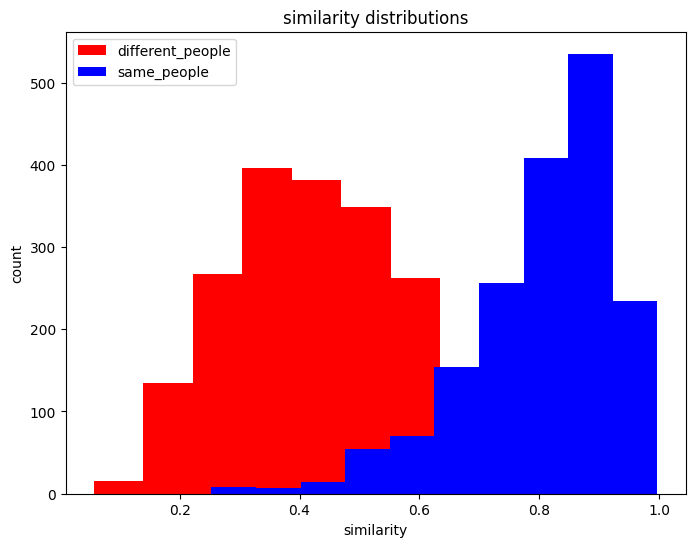

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))
series1 = np.array(list(map(lambda x: x.item(), same)))
series2 = np.array(list(map(lambda x: x.item(), diff)))

plt.hist(series2, label = 'different_people', color='red')
plt.hist(series1, label = 'same_people', color='blue')
plt.xlabel('similarity')
plt.ylabel('count')
plt.title('similarity distributions')

plt.legend()
plt.show()

Ну, в целом, распределения отличаются :)

##  Identificaton rate metric

When training the model above we used CE loss on val and test set as a measure of performance of our model. But this has a major disadvantage: we can't measure how godd a model would work on unseen faces (which are not present in training, val & test sets)

To address this we can calculate another metric for the model: **identification rate**. This is how it works:

We have two sets of faces: query and distractors. None of the faces from those sets are present in train, val or test sets.

1. calculate cosine similarities between all the faces corresponding to the same people from query dataset. This means if the person has 3 photos in query part: 01.jpg, 02.jpg, 03.jpg, then calculate 3 cosine similarities between every pair of embeddings corresponding to those photos.
2. calculate cosine similarities between all the faces corresponding to the different people from query dataset.
3. calculate cosine similarities between all the pairs of embeddings corresponding to query and distractors. This means calculate similarities between pairs (q, d), where q is the embedding that corresponds to a face from query, d — embedding that corresponds to a face from distractors. You'll get |query|*|distractors| similarities.
4. Sum numbers of similarities from 2 and 3 stages. This is a number of false pairs.
5. fix **FPR** (false positive rate). Let it be 0.01 in our case. FPR multiplied by a number of false pairs from the stage 4 is the number of false positives we would allow our model to make. Let's call this number N
6. Sort all the similarities of false pairs by descending order. Get the Nth element from the beginning — that's our **threshold similarity**.
7. Calculate how many positive similarities from stage 1 are equal or more that threshold. Divide this number by whole number of positive similarities from stage 1. This is TPR (true positive rate) — our metric.

This metric can also be expressed as TPR@FPR=0.01. FPR can vary.

Datasets (query photos, query labels & distructors photos) we can download using the code below. **Note that these images are already aligned and cropped**.

In [16]:
! curl -L $(yadisk-direct https://disk.yandex.com/d/KN4EEkNKrF_ZXQ) -o celebA_ir.zip
! unzip -qq celebA_ir.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 8978k  100 8978k    0     0  1447k      0  0:00:06  0:00:06 --:--:-- 2429k


In [17]:
from collections import defaultdict

# file with query part annotations: which image belongs to which class
# format:
#     image_name_1.jpg 2678
#     image_name_2.jpg 2679
f = open('./celebA_ir/celebA_anno_query.csv', 'r')
query_lines = f.readlines()[1:]
f.close()
query_lines = [x.strip().split(',') for x in query_lines]
# plain list of image names from query. Neede to compute embeddings for query
query_img_names = [x[0] for x in query_lines]

# dictionary with info of which images from query belong to which class
# format:
#     {class: [image_1, image_2, ...]}
query_dict = defaultdict(list)
for img_name, img_class in query_lines:
  query_dict[img_class].append(img_name)

# list of distractor images
distractors_img_names = os.listdir('./celebA_ir/celebA_distractors')

In [20]:
model = classify_model()
model.load_state_dict(torch.load('model_classif1 (1)'))

<All keys matched successfully>

In [21]:
model = model.to(device)

In [22]:
model_wo_last = copy.deepcopy(model)
model_wo_last.head = model_wo_last.head[:4]
model_wo_last.head

Sequential(
  (0): Linear(in_features=512, out_features=1024, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=1024, out_features=1024, bias=True)
)

In [23]:
model_wo_last.train(False)
print()

In [24]:
import gc

def compute_embeddings(model, images_list, is_query):
  '''
  compute embeddings from the trained model for list of images.
  params:
    model: trained nn model that takes images and outputs embeddings
    images_list: list of images paths to compute embeddings for
  output:
    list: list of model embeddings. Each embedding corresponds to images
          names from images_list
  '''
  answ = []
  for path in tqdm(images_list):
      if is_query:
        image = np.array(Image.open('celebA_ir/celebA_query/' + path))
      else:
        image = np.array(Image.open('celebA_ir/celebA_distractors/' + path))
      image = Image.fromarray(image)
      image = transform(image)
      img = image.unsqueeze(0).to(device)
      out = model(img).squeeze().detach().cpu().numpy()
      answ.append(out / (out ** 2).sum() ** 0.5)
      del image, img, out
  return answ

In [ ]:
image = np.array(Image.open('celebA_ir/celebA_query/' + query_img_names[0]))
image = Image.fromarray(image)
transform(image).shape

torch.Size([3, 192, 160])

In [ ]:
query_embeddings = compute_embeddings(model_wo_last, query_img_names, 1)
distractors_embeddings = compute_embeddings(model_wo_last, distractors_img_names, 0)

100%|██████████| 2001/2001 [00:25<00:00, 77.35it/s] 


In [ ]:
len(query_embeddings), len(distractors_embeddings)

(1222, 2001)

In [ ]:
query_embeddings[0].shape, (query_embeddings[0] ** 2).sum()

((1024,), 1.0)

In [ ]:
query_embeddings_dict = {}
for i, el in enumerate(query_img_names):
  query_embeddings_dict[el] = query_embeddings[i]
distractors_embeddings_dict = {}
for i, el in enumerate(distractors_img_names):
  distractors_embeddings_dict[el] = distractors_embeddings[i]

In [72]:
cos = nn.CosineSimilarity(dim=0, eps=1e-6)

In [73]:
def compute_cosine_query_pos(query_dict, query_img_names, query_embeddings_dict):
  '''
  compute cosine similarities between positive pairs from query (stage 1)
  params:
    query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                the dataset. Value: images corresponding to that class
    query_img_names: list of images names
    query_embeddings: list of embeddings corresponding to query_img_names
  output:
    list of floats: similarities between embeddings corresponding
                    to the same people from query list
  '''
  sims = []
  for clas in query_dict:
    for i, img_name in enumerate(query_dict[clas]):
      for j in range(i + 1, len(query_dict[clas])):
        sims.append(cos(torch.tensor(query_embeddings_dict[query_dict[clas][i]]),
                        torch.tensor(query_embeddings_dict[query_dict[clas][j]])))
  return sims

def compute_cosine_query_neg(query_dict, query_img_names, query_embeddings_dict):
  '''
  compute cosine similarities between negative pairs from query (stage 2)
  params:
    query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                the dataset. Value: images corresponding to that class
    query_img_names: list of images names
    query_embeddings: list of embeddings corresponding to query_img_names
  output:
    list of floats: similarities between embeddings corresponding
                    to different people from query list
  '''
  sims = []
  query_img_names_to_class = {}
  for clas in query_dict:
    for name in query_dict[clas]:
      query_img_names_to_class[name] = clas

  for i, name in enumerate(query_img_names):
    for j in range(i + 1, len(query_img_names)):
      if query_img_names_to_class[query_img_names[i]] != query_img_names_to_class[query_img_names[j]]:
        sims.append(cos(torch.tensor(query_embeddings_dict[query_img_names[i]]),
                        torch.tensor(query_embeddings_dict[query_img_names[j]])))
  return sims

def compute_cosine_query_distractors(query_embeddings, distractors_embeddings):
  '''
  compute cosine similarities between negative pairs from query and distractors
  (stage 3)
  params:
    query_embeddings: list of embeddings corresponding to query_img_names
    distractors_embeddings: list of embeddings corresponding to distractors_img_names
  output:
    list of floats: similarities between pairs of people (q, d), where q is
                    embedding corresponding to photo from query, d —
                    embedding corresponding to photo from distractors
  '''
  sims = []
  for el1 in query_embeddings:
    for el2 in distractors_embeddings:
      sims.append(cos(torch.tensor(el1),
                      torch.tensor(el2)))
  return sims

In [ ]:
cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names,
                                            query_embeddings_dict)
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names,
                                            query_embeddings_dict)
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings,
                                                            distractors_embeddings)


Check you code of functions which compute similarities:

In [ ]:
test_query_dict = {
    2876: ['1.jpg', '2.jpg', '3.jpg'],
    5674: ['5.jpg'],
    864:  ['9.jpg', '10.jpg'],
}
test_query_img_names = ['1.jpg', '2.jpg', '3.jpg', '5.jpg', '9.jpg', '10.jpg']
test_query_embeddings = [
                    [1.56, 6.45,  -7.68],
                    [-1.1 , 6.11,  -3.0],
                    [-0.06,-0.98,-1.29],
                    [8.56, 1.45,  1.11],
                    [0.7,  1.1,   -7.56],
                    [0.05, 0.9,   -2.56],
]

test_distractors_img_names = ['11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg']

test_distractors_embeddings = [
                    [0.12, -3.23, -5.55],
                    [-1,   -0.01, 1.22],
                    [0.06, -0.23, 1.34],
                    [-6.6, 1.45,  -1.45],
                    [0.89,  1.98, 1.45],
]

test_query_embeddings_dict = {}
for i, el in enumerate(test_query_img_names):
  test_query_embeddings_dict[el] = test_query_embeddings[i]
test_distractors_embeddings_dict = {}
for i, el in enumerate(test_distractors_img_names):
  test_distractors_embeddings_dict[el] = test_distractors_embeddings[i]

test_cosine_query_pos = compute_cosine_query_pos(test_query_dict, test_query_img_names,
                                            test_query_embeddings_dict)
test_cosine_query_neg = compute_cosine_query_neg(test_query_dict, test_query_img_names,
                                            test_query_embeddings_dict)
test_cosine_query_distractors = compute_cosine_query_distractors(test_query_embeddings,
                                                            test_distractors_embeddings)

In [ ]:
true_cosine_query_pos = [0.8678237233650096, 0.21226104378511604,
                         -0.18355866977496182, 0.9787437979250561]
assert np.allclose(sorted(test_cosine_query_pos), sorted(true_cosine_query_pos)), \
      "A mistake in compute_cosine_query_pos function"

true_cosine_query_neg = [0.15963231223161822, 0.8507997093616965, 0.9272761484302097,
                         -0.0643994061127092, 0.5412660901220571, 0.701307100338029,
                         -0.2372575528216902, 0.6941032794522218, 0.549425446066643,
                         -0.011982733001947084, -0.0466679194884999]
assert np.allclose(sorted(test_cosine_query_neg), sorted(true_cosine_query_neg)), \
      "A mistake in compute_cosine_query_neg function"

true_cosine_query_distractors = [0.3371426578637511, -0.6866465610863652, -0.8456563512871669,
                                 0.14530087113136106, 0.11410510307646118, -0.07265097629002357,
                                 -0.24097699660707042,-0.5851992679925766, 0.4295494455718534,
                                 0.37604478596058194, 0.9909483738948858, -0.5881093317868022,
                                 -0.6829712976642919, 0.07546364489032083, -0.9130970963915521,
                                 -0.17463101988684684, -0.5229363015558941, 0.1399896725311533,
                                 -0.9258034013399499, 0.5295114163723346, 0.7811585442749943,
                                 -0.8208760031249596, -0.9905139680301821, 0.14969764653247228,
                                 -0.40749654525418444, 0.648660814944824, -0.7432584300096284,
                                 -0.9839696492435877, 0.2498741082804709, -0.2661183373780491]
assert np.allclose(sorted(test_cosine_query_distractors), sorted(true_cosine_query_distractors)), \
      "A mistake in compute_cosine_query_distractors function"
print('all good!')

all good!


Implement the final function: identification rate calculation

In [26]:
def compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors,
               fpr=0.1):
  '''
  compute identification rate using precomputer cosine similarities between pairs
  at given fpr
  params:
    cosine_query_pos: cosine similarities between positive pairs from query
    cosine_query_neg: cosine similarities between negative pairs from query
    cosine_query_distractors: cosine similarities between negative pairs
                              from query and distractors
    fpr: false positive rate at which to compute TPR
  output:
    float: threshold for given fpr
    float: TPR at given FPR
  '''
  false_pairs = len(cosine_query_neg) + len(cosine_query_distractors)
  N = int(false_pairs * fpr)
  all_neg = cosine_query_neg + cosine_query_distractors
  all_neg = np.array(list(map(lambda x: -x.item(), all_neg)))
  threshold = -np.partition(np.asarray(all_neg), N)[N]
  return threshold, (np.array(list(map(lambda x: x.item(), cosine_query_pos))) >= threshold).sum() / len(cosine_query_pos)

Check:

In [ ]:
test_thr = []
test_tpr = []
for fpr in [0.5, 0.3, 0.1]:
  x, y = compute_ir(test_cosine_query_pos, test_cosine_query_neg,
                    test_cosine_query_distractors, fpr=fpr)
  test_thr.append(x)
  test_tpr.append(y)

In [ ]:
true_thr = [-0.011982733001947084, 0.3371426578637511, 0.701307100338029]
assert np.allclose(np.array(test_thr), np.array(true_thr)), "A mistake in computing threshold"

true_tpr = [0.75, 0.5, 0.5]
assert np.allclose(np.array(test_tpr), np.array(true_tpr)), "A mistake in computing tpr"
print('nice!')

nice!


Finally compute tpr for faces query and distractors dataset and fpr = [0.5, 0.2, 0.1, 0.05]:

In [ ]:
fpr = [0.5, 0.2, 0.1, 0.05]
metric = []
for el in tqdm(fpr):
  metric.append(compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors,
               fpr=el))

100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


In [ ]:
metric

[(0.43869855999946594, 0.967257659126418),
 (0.5661641955375671, 0.8521839548943686),
 (0.631172776222229, 0.7354799266354188),
 (0.6821661591529846, 0.6083825827049792)]

То есть при допуске 50% false positive мы получаем трешхолд 0.44 и true positive rate - 97%

## Alternative Loss function

Building a network before we used an ordinary CE loss. But there are many more variants of loss functions that can be used to train neural network. We will discuss two of them, which are the most popular. More examples of losses for face recognition and their performance reviews you can find in this paper: https://arxiv.org/pdf/1901.05903.pdf

Here we will concentrate on ArcFace loss, which was first designed specifically for Face Recognition task and shows great performance in it.

### ArcFace Loss (Additive Angular Margin Loss)

This loss is somewhat "SOTA" for face recognition systems (somewhat — because actually different variants of losses and their combinations may be the best for different network architectures). This loss inherits idea from CE loss but further develops it to achieve better embeddings distribution on a sphere. It introduces some geodesic constraints to enhance intra-class compactness and inter-class discrepancy.



**How ArcFace loss works**:

This loss is a variation of a standard SoftMax CE loss, which enforces embeddings of different classes (people) be further away: have a more sparse representation of embeddings in embedding space, enforce more evident gap between the nearest classes.

The standard SoftMax CE loss for classification task is presented as follows:

$$L_{CE} = \frac{-1}{N}\sum_1^N \frac{e^{W_{y_i}^{T}x_i + b_{y_i}}}{\sum^n_{j=1}e^{W_j^Tx_i+b_j}},$$

where:
- $x_i \in \mathbb{R^d}$ denotes the deep feature of the $i$-th sample, belonging to the $y_i$-th class;
- $W_j \in \mathbb{R^d}$ denotes the j-th column of the weight;
- $W \in \mathbb{R^d}$ and $b_j \in \mathbb{R^d}$ is the bias term;
- $N$ — batch size;
- $n$ — class number.

It appears, that, though this loss works well, it does not explicitly optimise the feature embedding to enforce higher similarity for intra- class samples and diversity for inter-class samples, which results in a performance gap for deep face recognition under large intra-class appearance variations.

Let's do some work on this loss formula:
- fix the bias $b_j=0$;
- normalize weight ||$W_j$|| = 1;
- normalize embedding ||$x_i$|| = 1 and re-scale it to s (s is a hyperparameter)

The normalisation step on embeddings and weights makes the predictions only depend on the angle between the embedding and the weight. The learned embeddings fare thus distributed on a hypersphere with a radius of s.

So we get the following loss function now:

$$L = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos\Theta_{y_i}}}{e^{s\ cos\Theta_{y_i}} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

Final step: let's add an additive angular margin penalty $m$ between $x_i$ and $W_{y_i}$ to simultaneously enhance the intra-class compactness and inter-class discrepancy:

$$L_{ArcFace} = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos(\Theta_{y_i} + m)}}{e^{s\ cos(\Theta_{y_i} + m)} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

SO this is an ArcFace loss. It has 2 hyperparameters: s and m.

The original paper to read about ArcFace more precisely: https://arxiv.org/pdf/1801.07698.pdf

The original repo, where you can find a code sample: https://github.com/deepinsight/insightface

Определим главное - нашу функцию потерь!

In [37]:
class ArcFaceLoss(nn.Module):
    def __init__(self, last_layer, num_classes=500, embedding_size=1024, margin=0.3, scale=30):
        super().__init__()
        self.num_classes = num_classes
        self.embedding_size = embedding_size
        self.margin = margin
        self.scale = scale
        self.W = last_layer.weight

    def forward(self, embeddings, labels):
        cosine = self.get_cosine(embeddings)
        mask = self.get_target_mask(labels)
        cosine_of_target_classes = cosine[mask == 1]
        modified_cosine_of_target_classes = self.modify_cosine_of_target_classes(
            cosine_of_target_classes
        )
        diff = (modified_cosine_of_target_classes - cosine_of_target_classes).unsqueeze(1)
        logits = cosine + (mask * diff)
        logits = self.scale_logits(logits)
        return nn.CrossEntropyLoss()(logits, labels)

    def get_cosine(self, embeddings):
        cosine = F.linear(F.normalize(embeddings), F.normalize(self.W))
        return cosine

    def get_target_mask(self, labels):
        batch_size = labels.size(0)
        onehot = torch.zeros(batch_size, self.num_classes, device=labels.device)
        onehot.scatter_(1, labels.unsqueeze(-1), 1)
        return onehot

    def modify_cosine_of_target_classes(self, cosine_of_target_classes):
        eps = 1e-6
        angles = torch.acos(torch.clamp(cosine_of_target_classes, -1 + eps, 1 - eps))
        return torch.cos(angles + self.margin)

    def scale_logits(self, logits):
        return logits * self.scale

Немного поменяем модель, так как лосс по сути считается исходя из предпоследнего и последнего слоев  (для этого я их разделяю в модели)

In [38]:
class classify_model_arc_loss(nn.Module):
    def __init__(self):
        super(classify_model_arc_loss, self).__init__()
        model = resnet18(pretrained=True)
        model.fc = nn.Identity()
        self.resnet = model
        self.head = nn.Sequential(
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 1024)
        )
        self.last = nn.Linear(1024, 500)
        self.loss_function = ArcFaceLoss(
                num_classes=500,
                last_layer = self.last,
                embedding_size=1024,
                margin=0.3,
                scale=30.0
            )

    def forward(self, x):
        x = x.to(device)
        return self.head(self.resnet(x))

In [39]:
model_arc_loss = classify_model_arc_loss()
model_arc_loss = model_arc_loss.to(device)
for param in model_arc_loss.resnet.parameters(): # сначала поучим только голову
    param.requires_grad = False
optimizer = torch.optim.Adam(model_arc_loss.parameters(), weight_decay=1e-4)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Тренировочный цикл тоже чутка надо переделать, а именно то место, где мы делаем forward pass

In [40]:
import numpy as np
import time
from tqdm import tqdm


def eval_model(model, data_generator):
    accuracy = []
    model.train(False) # disable dropout / use averages for batch_norm
    with torch.no_grad():
        for batch in data_generator:
            X_batch = batch['image'].to(device)
            y_batch = batch['label'].to(device)
            logits = model.last(model(X_batch))
            y_pred = logits.max(1)[1].data
            accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))
    return np.mean(accuracy)


def train_model(model, optimizer, train_data_generator):
    train_loss = []
    model.train(True) # enable dropout / batch_norm training behavior
    for batch in tqdm(train_data_generator):
        X_batch = batch['image'].to(device)
        y_batch = batch['label'].to(device)
        optimizer.zero_grad()

        embs = model(X_batch)
        predictions = model.last(embs)                          # ВОТ ТУТ ПОМЕНЯЛ ТРИ СТРОЧКИ
        loss = model.loss_function(embs, y_batch)

        # backward
        loss.backward()
        optimizer.step()

        # metrics
        train_loss.append(loss.cpu().data.numpy())
    return np.mean(train_loss)


def train_loop(model, optimizer, train_data_generator, val_data_generator, num_epochs):
    """
    num_epochs - total amount of full passes over training data
    """
    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss = train_model(model, optimizer, train_data_generator)

        val_accuracy = eval_model(model, val_data_generator)

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_accuracy * 100))

Будем обучать по той же схеме, чтобы было честно

In [41]:
train_loop(model_arc_loss, optimizer, train_loader, val_loader, num_epochs=20)

100%|██████████| 134/134 [00:30<00:00,  4.41it/s]


Epoch 1 of 20 took 35.696s
  training loss (in-iteration): 	15.577373
  validation accuracy: 			1.15 %


100%|██████████| 134/134 [00:30<00:00,  4.43it/s]


Epoch 2 of 20 took 34.967s
  training loss (in-iteration): 	14.249371
  validation accuracy: 			7.23 %


100%|██████████| 134/134 [00:25<00:00,  5.19it/s]


Epoch 3 of 20 took 30.301s
  training loss (in-iteration): 	13.340791
  validation accuracy: 			12.65 %


100%|██████████| 134/134 [00:25<00:00,  5.24it/s]


Epoch 4 of 20 took 30.099s
  training loss (in-iteration): 	12.646753
  validation accuracy: 			16.23 %


100%|██████████| 134/134 [00:25<00:00,  5.33it/s]


Epoch 5 of 20 took 29.832s
  training loss (in-iteration): 	12.011791
  validation accuracy: 			18.76 %


100%|██████████| 134/134 [00:23<00:00,  5.75it/s]


Epoch 6 of 20 took 28.031s
  training loss (in-iteration): 	11.348434
  validation accuracy: 			19.93 %


100%|██████████| 134/134 [00:24<00:00,  5.39it/s]


Epoch 7 of 20 took 30.246s
  training loss (in-iteration): 	10.756807
  validation accuracy: 			20.13 %


100%|██████████| 134/134 [00:23<00:00,  5.59it/s]


Epoch 8 of 20 took 29.461s
  training loss (in-iteration): 	10.212676
  validation accuracy: 			22.84 %


100%|██████████| 134/134 [00:22<00:00,  5.89it/s]


Epoch 9 of 20 took 28.247s
  training loss (in-iteration): 	9.778845
  validation accuracy: 			22.95 %


100%|██████████| 134/134 [00:22<00:00,  5.83it/s]


Epoch 10 of 20 took 28.383s
  training loss (in-iteration): 	9.348152
  validation accuracy: 			23.84 %


100%|██████████| 134/134 [00:23<00:00,  5.63it/s]


Epoch 11 of 20 took 28.975s
  training loss (in-iteration): 	8.971614
  validation accuracy: 			23.73 %


100%|██████████| 134/134 [00:23<00:00,  5.63it/s]


Epoch 12 of 20 took 28.822s
  training loss (in-iteration): 	8.718124
  validation accuracy: 			23.62 %


100%|██████████| 134/134 [00:23<00:00,  5.60it/s]


Epoch 13 of 20 took 28.721s
  training loss (in-iteration): 	8.468325
  validation accuracy: 			24.29 %


100%|██████████| 134/134 [00:24<00:00,  5.40it/s]


Epoch 14 of 20 took 29.462s
  training loss (in-iteration): 	8.308754
  validation accuracy: 			23.88 %


100%|██████████| 134/134 [00:23<00:00,  5.67it/s]


Epoch 15 of 20 took 28.176s
  training loss (in-iteration): 	8.117368
  validation accuracy: 			24.35 %


100%|██████████| 134/134 [00:24<00:00,  5.57it/s]


Epoch 16 of 20 took 28.811s
  training loss (in-iteration): 	7.842122
  validation accuracy: 			24.04 %


100%|██████████| 134/134 [00:23<00:00,  5.62it/s]


Epoch 17 of 20 took 28.525s
  training loss (in-iteration): 	7.660778
  validation accuracy: 			25.44 %


100%|██████████| 134/134 [00:29<00:00,  4.57it/s]


Epoch 18 of 20 took 39.747s
  training loss (in-iteration): 	7.521951
  validation accuracy: 			25.60 %


100%|██████████| 134/134 [00:28<00:00,  4.63it/s]


Epoch 19 of 20 took 34.714s
  training loss (in-iteration): 	7.405078
  validation accuracy: 			24.14 %


100%|██████████| 134/134 [00:30<00:00,  4.37it/s]


Epoch 20 of 20 took 37.840s
  training loss (in-iteration): 	7.316071
  validation accuracy: 			24.55 %


In [43]:
for param in model_arc_loss.resnet.parameters(): # теперь обучаем все вместе
    param.requires_grad = True
optimizer = torch.optim.Adam(model_arc_loss.parameters(), weight_decay=1e-4)

In [44]:
train_loop(model_arc_loss, optimizer, train_loader, val_loader, num_epochs=20)

100%|██████████| 134/134 [00:33<00:00,  4.06it/s]


Epoch 1 of 20 took 37.683s
  training loss (in-iteration): 	12.466090
  validation accuracy: 			30.95 %


100%|██████████| 134/134 [00:32<00:00,  4.13it/s]


Epoch 2 of 20 took 37.500s
  training loss (in-iteration): 	9.504698
  validation accuracy: 			38.57 %


100%|██████████| 134/134 [00:33<00:00,  4.05it/s]


Epoch 3 of 20 took 38.128s
  training loss (in-iteration): 	7.335291
  validation accuracy: 			49.69 %


100%|██████████| 134/134 [00:34<00:00,  3.85it/s]


Epoch 4 of 20 took 42.894s
  training loss (in-iteration): 	5.457138
  validation accuracy: 			51.56 %


100%|██████████| 134/134 [00:32<00:00,  4.16it/s]


Epoch 5 of 20 took 37.225s
  training loss (in-iteration): 	3.818883
  validation accuracy: 			56.52 %


100%|██████████| 134/134 [00:32<00:00,  4.13it/s]


Epoch 6 of 20 took 36.790s
  training loss (in-iteration): 	2.606444
  validation accuracy: 			63.85 %


100%|██████████| 134/134 [00:33<00:00,  3.98it/s]


Epoch 7 of 20 took 38.086s
  training loss (in-iteration): 	1.632572
  validation accuracy: 			68.48 %


100%|██████████| 134/134 [00:32<00:00,  4.15it/s]


Epoch 8 of 20 took 37.778s
  training loss (in-iteration): 	0.965445
  validation accuracy: 			70.49 %


100%|██████████| 134/134 [00:34<00:00,  3.86it/s]


Epoch 9 of 20 took 39.857s
  training loss (in-iteration): 	0.644775
  validation accuracy: 			72.21 %


100%|██████████| 134/134 [00:32<00:00,  4.10it/s]


Epoch 10 of 20 took 37.014s
  training loss (in-iteration): 	0.417728
  validation accuracy: 			73.70 %


100%|██████████| 134/134 [00:36<00:00,  3.67it/s]


Epoch 11 of 20 took 41.124s
  training loss (in-iteration): 	0.279697
  validation accuracy: 			73.77 %


100%|██████████| 134/134 [00:38<00:00,  3.48it/s]


Epoch 12 of 20 took 43.301s
  training loss (in-iteration): 	0.239941
  validation accuracy: 			72.58 %


100%|██████████| 134/134 [00:38<00:00,  3.52it/s]


Epoch 13 of 20 took 42.404s
  training loss (in-iteration): 	0.226438
  validation accuracy: 			72.58 %


100%|██████████| 134/134 [00:32<00:00,  4.18it/s]


Epoch 14 of 20 took 37.863s
  training loss (in-iteration): 	0.222122
  validation accuracy: 			70.97 %


100%|██████████| 134/134 [00:32<00:00,  4.10it/s]


Epoch 15 of 20 took 37.418s
  training loss (in-iteration): 	0.271444
  validation accuracy: 			70.02 %


100%|██████████| 134/134 [00:37<00:00,  3.59it/s]


Epoch 16 of 20 took 44.289s
  training loss (in-iteration): 	0.547820
  validation accuracy: 			64.63 %


100%|██████████| 134/134 [00:34<00:00,  3.92it/s]


Epoch 17 of 20 took 38.421s
  training loss (in-iteration): 	0.820166
  validation accuracy: 			65.62 %


100%|██████████| 134/134 [00:35<00:00,  3.80it/s]


Epoch 18 of 20 took 41.019s
  training loss (in-iteration): 	0.722376
  validation accuracy: 			70.50 %


100%|██████████| 134/134 [00:33<00:00,  4.04it/s]


Epoch 19 of 20 took 37.683s
  training loss (in-iteration): 	0.358315
  validation accuracy: 			72.59 %


100%|██████████| 134/134 [00:37<00:00,  3.60it/s]


Epoch 20 of 20 took 42.178s
  training loss (in-iteration): 	0.185521
  validation accuracy: 			74.13 %


Тут уже после 30 эпох выбили 70% на валидации, то есть с таким лоссом объективно лучше

Но дообучим еще 20 эпох, как мы делали с той моделью, для чистоты эксперимента

In [45]:
for param in optimizer.param_groups:
  param['lr'] = 1e-4

In [46]:
train_loop(model_arc_loss, optimizer, train_loader, val_loader, num_epochs=20)

100%|██████████| 134/134 [00:32<00:00,  4.07it/s]


Epoch 1 of 20 took 38.456s
  training loss (in-iteration): 	0.069224
  validation accuracy: 			76.84 %


100%|██████████| 134/134 [00:39<00:00,  3.42it/s]


Epoch 2 of 20 took 44.444s
  training loss (in-iteration): 	0.035862
  validation accuracy: 			77.67 %


100%|██████████| 134/134 [00:32<00:00,  4.09it/s]


Epoch 3 of 20 took 37.635s
  training loss (in-iteration): 	0.027514
  validation accuracy: 			78.08 %


100%|██████████| 134/134 [00:33<00:00,  3.95it/s]


Epoch 4 of 20 took 38.372s
  training loss (in-iteration): 	0.021268
  validation accuracy: 			78.03 %


100%|██████████| 134/134 [00:39<00:00,  3.42it/s]


Epoch 5 of 20 took 43.975s
  training loss (in-iteration): 	0.019063
  validation accuracy: 			78.24 %


100%|██████████| 134/134 [00:35<00:00,  3.72it/s]


Epoch 6 of 20 took 40.340s
  training loss (in-iteration): 	0.016406
  validation accuracy: 			78.76 %


100%|██████████| 134/134 [00:34<00:00,  3.83it/s]


Epoch 7 of 20 took 39.725s
  training loss (in-iteration): 	0.015032
  validation accuracy: 			79.02 %


100%|██████████| 134/134 [00:35<00:00,  3.74it/s]


Epoch 8 of 20 took 40.655s
  training loss (in-iteration): 	0.013474
  validation accuracy: 			78.35 %


100%|██████████| 134/134 [00:34<00:00,  3.84it/s]


Epoch 9 of 20 took 40.955s
  training loss (in-iteration): 	0.012669
  validation accuracy: 			78.71 %


100%|██████████| 134/134 [00:33<00:00,  4.06it/s]


Epoch 10 of 20 took 37.629s
  training loss (in-iteration): 	0.012515
  validation accuracy: 			79.54 %


100%|██████████| 134/134 [00:33<00:00,  3.95it/s]


Epoch 11 of 20 took 38.311s
  training loss (in-iteration): 	0.010135
  validation accuracy: 			78.76 %


100%|██████████| 134/134 [00:38<00:00,  3.48it/s]


Epoch 12 of 20 took 42.979s
  training loss (in-iteration): 	0.010370
  validation accuracy: 			79.28 %


100%|██████████| 134/134 [00:32<00:00,  4.12it/s]


Epoch 13 of 20 took 37.718s
  training loss (in-iteration): 	0.009666
  validation accuracy: 			79.39 %


100%|██████████| 134/134 [00:33<00:00,  4.00it/s]


Epoch 14 of 20 took 38.671s
  training loss (in-iteration): 	0.008214
  validation accuracy: 			79.59 %


100%|██████████| 134/134 [00:32<00:00,  4.07it/s]


Epoch 15 of 20 took 37.282s
  training loss (in-iteration): 	0.009494
  validation accuracy: 			79.70 %


100%|██████████| 134/134 [00:32<00:00,  4.10it/s]


Epoch 16 of 20 took 37.107s
  training loss (in-iteration): 	0.008022
  validation accuracy: 			79.54 %


100%|██████████| 134/134 [00:32<00:00,  4.16it/s]


Epoch 17 of 20 took 37.595s
  training loss (in-iteration): 	0.006890
  validation accuracy: 			79.23 %


100%|██████████| 134/134 [00:32<00:00,  4.13it/s]


Epoch 18 of 20 took 36.864s
  training loss (in-iteration): 	0.007949
  validation accuracy: 			79.70 %


100%|██████████| 134/134 [00:32<00:00,  4.08it/s]


Epoch 19 of 20 took 37.379s
  training loss (in-iteration): 	0.007863
  validation accuracy: 			79.38 %


100%|██████████| 134/134 [00:32<00:00,  4.16it/s]


Epoch 20 of 20 took 37.470s
  training loss (in-iteration): 	0.006416
  validation accuracy: 			79.59 %


Даже почти до 80% accuracy дошли

In [48]:
from google.colab import files

torch.save(model_arc_loss.state_dict(), 'model_arc_loss1')
files.download('model_arc_loss1')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [49]:
def evaluate(model, dataloader):

    losses = []

    num_correct = 0
    num_elements = 0

    for i, batch in enumerate(dataloader):

        X_batch, y_batch = batch['image'], batch['label']
        num_elements += len(y_batch)

        with torch.no_grad():
            logits = model.last(model(X_batch.to(device)))

            embs = model(X_batch.to(device))
            predictions = model.last(embs)
            loss = model.loss_function(embs, y_batch.to(device))
            losses.append(loss.item())

            y_pred = torch.argmax(predictions, dim=1)

            num_correct += torch.sum(y_pred.cpu() == y_batch)

    accuracy = num_correct / num_elements

    return accuracy.numpy(), np.mean(losses)

In [50]:
test_accuracy, test_loss = evaluate(model_arc_loss, test_loader)
test_accuracy, test_loss

(array(0.7847703, dtype=float32), 4.09898567199707)

Все еще больше, чем у предыдущей модели :)

Теперь поймем насколько хорошие эмбеддинги у нас получились - для этого посчитаем метрику из задания 2

In [57]:
model_arc_loss.train(False)
print()

In [66]:
cos = nn.CosineSimilarity(dim=0, eps=1e-6)

In [67]:
query_embeddings = compute_embeddings(model_arc_loss, query_img_names, 1)
distractors_embeddings = compute_embeddings(model_arc_loss, distractors_img_names, 0)

100%|██████████| 2001/2001 [00:12<00:00, 158.13it/s]


In [68]:
query_embeddings_dict = {}
for i, el in enumerate(query_img_names):
  query_embeddings_dict[el] = query_embeddings[i]
distractors_embeddings_dict = {}
for i, el in enumerate(distractors_img_names):
  distractors_embeddings_dict[el] = distractors_embeddings[i]

In [74]:
cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names,
                                            query_embeddings_dict)
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names,
                                            query_embeddings_dict)
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings,
                                                            distractors_embeddings)

In [75]:
fpr = [0.5, 0.2, 0.1, 0.05]
metric = []
for el in tqdm(fpr):
  metric.append(compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors,
               fpr=el))
metric

100%|██████████| 4/4 [00:19<00:00,  4.88s/it]


[(0.020472217351198196, 0.9658311256028802),
 (0.19280408322811127, 0.8415868487195164),
 (0.2880138158798218, 0.7248828204605665),
 (0.36628320813179016, 0.5977175463623395)]

А вот результаты предыдущей модели:

[(0.43869855999946594, 0.967257659126418),

 (0.5661641955375671, 0.8521839548943686),

 (0.631172776222229, 0.7354799266354188),

 (0.6821661591529846, 0.6083825827049792)]

TPR почти такой же, а вот трешхолды гораздо ниже - видимо, мы сильно рассредотачиваем эмбеддинги картинок. Для разных людей это хорошо, а для одинаковых - не очень. Возможно, мы взяли слишком большую размерность эмбеддингов, и для такого лосса это не очень, но хотелось посмотреть на результаты одинаковых моделей, просто обученных разными лоссами

Можно еще посмотреть на распределения схожестей для negative и positive пар

In [58]:
same = []
diff = []
with torch.no_grad():
  for i in tqdm(range(0, 8544, 17)):
    if len(diff) > 2000 and len(same) > 2000:
      break
    img = train_data[i]['image'].unsqueeze(0).to(device)
    label = train_data[i]['label']
    out = model_arc_loss(img).squeeze()
    out /= (out ** 2).sum() ** 0.5
    for el in test_data:
      img_test = el['image'].unsqueeze(0).to(device)
      label_test = el['label']
      if label_test != label and len(diff) > 2000:
        continue
      if label_test == label and len(same) > 2000:
        continue
      out_test = model_arc_loss(img_test).squeeze()
      out_test /= (out_test ** 2).sum() ** 0.5
      if label_test != label:
        diff.append(cos(out, out_test))
      if label_test == label:
        same.append(cos(out, out_test))

100%|██████████| 503/503 [25:45<00:00,  3.07s/it]


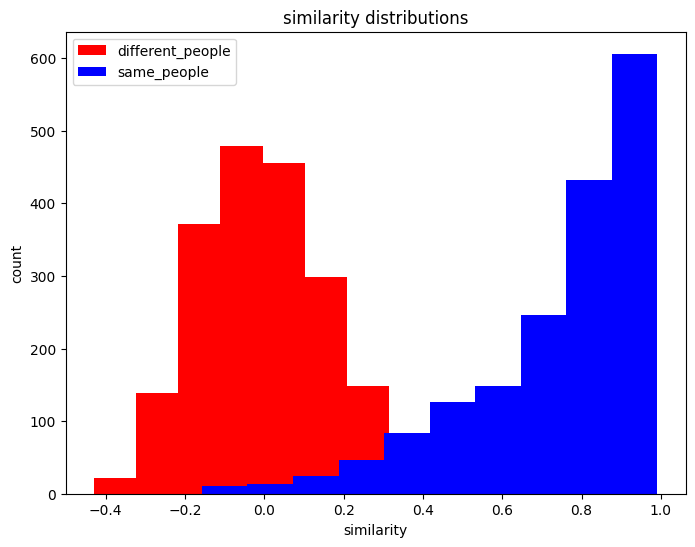

In [59]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))
series1 = np.array(list(map(lambda x: x.item(), same)))
series2 = np.array(list(map(lambda x: x.item(), diff)))

plt.hist(series2, label = 'different_people', color='red')
plt.hist(series1, label = 'same_people', color='blue')
plt.xlabel('similarity')
plt.ylabel('count')
plt.title('similarity distributions')

plt.legend()
plt.show()

Как будто тут распределения более разрозненные, чем для той модели, что хорошо